In [1]:
import os
import numpy as np
import pandas as pd
from pixc2profile import download_pixc_data
from pixc2profile.river import River
from pixc2profile.pixc import PIXC
from pixc2profile.profile import Profile

In [2]:
# List all information below
home_dir = "/mnt/d/pixc2profile/examples/data"
river_name = "test_river"
start_date = "2024-01-01"
end_date = "2024-03-01"
pass_tile_list = ["454_082L", "454_083L", "191_227L", "191_227R", "191_226R"]
pixc_version = "SWOT_L2_HR_PIXC_2.0"
login_strategy = 'netrc'

# Step 1: Download PIXC data
download_pixc_data(home_dir=home_dir,
                   riv_name=river_name,
                   start_date=start_date,
                   end_date=end_date,
                   pass_tile_list=pass_tile_list,
                   )


QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

Downloaded 4 PIXC files to /mnt/d/pixc2profile/examples/data/test_river/SWOT_L2_HR_PIXC_2.0


['/mnt/d/pixc2profile/examples/data/test_river/SWOT_L2_HR_PIXC_2.0/SWOT_L2_HR_PIXC_009_191_226R_20240110T230656_20240110T230708_PIC0_01.nc',
 '/mnt/d/pixc2profile/examples/data/test_river/SWOT_L2_HR_PIXC_2.0/SWOT_L2_HR_PIXC_009_191_226R_20240110T230656_20240110T230708_PGC0_01.nc',
 '/mnt/d/pixc2profile/examples/data/test_river/SWOT_L2_HR_PIXC_2.0/SWOT_L2_HR_PIXC_010_191_226R_20240131T195203_20240131T195214_PIC0_01.nc',
 '/mnt/d/pixc2profile/examples/data/test_river/SWOT_L2_HR_PIXC_2.0/SWOT_L2_HR_PIXC_011_191_226R_20240221T163708_20240221T163719_PIC0_01.nc']

/home/xinchenh/anaconda3/envs/swot/lib/python3.13/site-packages/pixc2profile/river.py:325: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


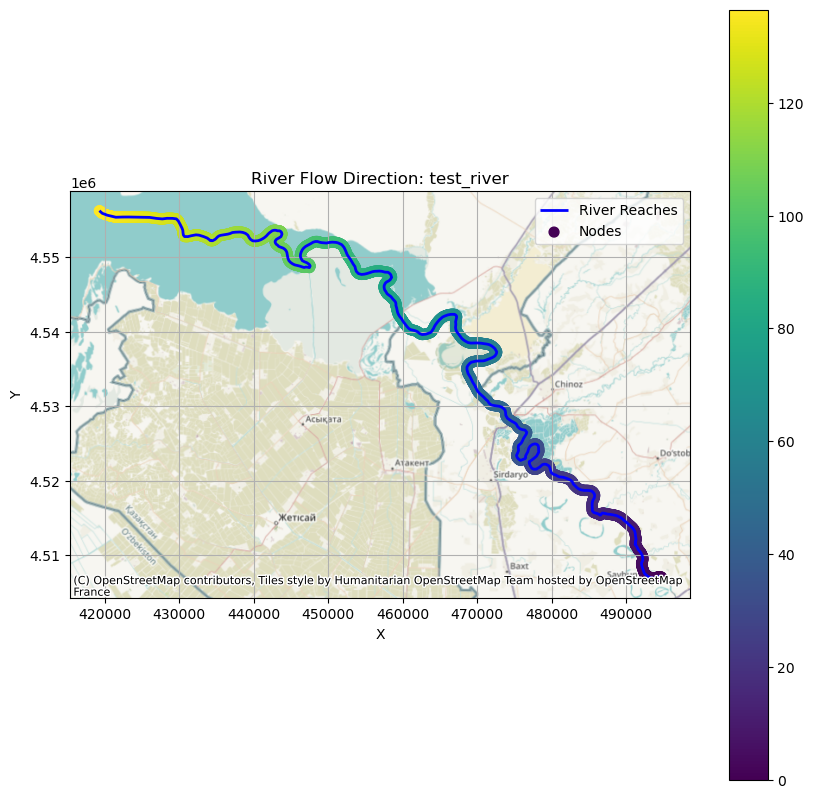

In [3]:
# Step 2: Create River object; Generate nodes and buffers
# make sure the river shapefile follows a correct topological order (from upstream to downstream)
river_shp_path = os.path.join(home_dir, "shps", "test_river.shp")
# create a node every 50 meters
node_spacing = 50 # m
# approximate river channel width for buffer generation
channel_width = 260 # m

# Initiate a river object
river = River(home_dir=home_dir,
              riv_name=river_name,
              riv_shp_path = river_shp_path,
              node_spacing = node_spacing,
              riv_width = channel_width,
              )
# generate node, create buffer, then export both shapefiles to "home_dir/river_name/nodes/"
# river.generate_nodes()
# river.generate_buffers()
# river.export_shapefiles()

# or just call process_river to do all above steps
river.process_river()

# plot streamwise distance to check if the nodes are correctly generated
river.plot_flow_direction()

'/mnt/d/pixc2profile/examples/data/test_river/nodes/nodes_50m.shp'

In [ ]:
# Step 3: Create PIXC object; Extract PIXC data within buffers
pixc_water_dir_name="pixc_water"
pixc_qc_dirname="pixc_water_qc_filtered"
pixc_dirname = pixc_version
n_partitions = 10
classification_categories = [3, 4] # "water near land" and "open water"
prior_water_prob_threshold = 0.5 # Pekel et al. (2016)
water_frac_threshold = 0.2 # fraction of water
wse_upper_limit = 400 # m, upper limit of WSE to exclude outliers; choose a high value if unsure

# initiate PIXC object
pixc = PIXC(home_dir=home_dir,
            riv_name=river_name,
            pixc_dirname=pixc_dirname,
            var_list=None,
            create_ref_table_on_init=True)

# extract water pixels within buffers
pixc_water_paths = pixc.process_water_pixels(node_buffer_path=river.buffer_export_path,
                          pixc_water_dir_name=pixc_water_dir_name,
                          n_parts=n_partitions,
                          classification_categories=classification_categories,
                            prior_water_prob_threshold=prior_water_prob_threshold,
                            water_frac_threshold=water_frac_threshold
                          )
# data exported to "pixc_water/{date}_water.csv" under each river folder
print(pixc_water_paths[0])

# filter with quality flags
# here we show an example of filtering based on geolocation quality flags, removal pixels labeled with 4, 64, and 68
quality_flag_dict = {
    "geolocation_qual": [4, 64, 68]
}

pixc_water_qc_filtered_paths = pixc.filter_with_quality_flags(
    pixc_water_paths=pixc.pixc_water_paths,
    quality_flag_dict=quality_flag_dict,
    pixc_qc_dirname=pixc_qc_dirname
    )
# data exported to "pixc_water_qc_filtered/{date}_water_qc_filtered.csv" under each river folder
print(pixc_water_qc_filtered_paths[0])

Found 18 PIXC files in /mnt/d/pixc2profile/examples/data/test_river/SWOT_L2_HR_PIXC_2.0


Filtering water pixels within node buffers: 100%|██████████| 5/5 [02:08<00:00, 25.63s/it]


/mnt/d/pixc2profile/examples/data/test_river/pixc_water/20240110_water.csv


Filtering PIXC water points with quality flags: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]

/mnt/d/pixc2profile/examples/data/test_river/pixc_water_qc_filtered/20240110_water_qc_filtered.csv


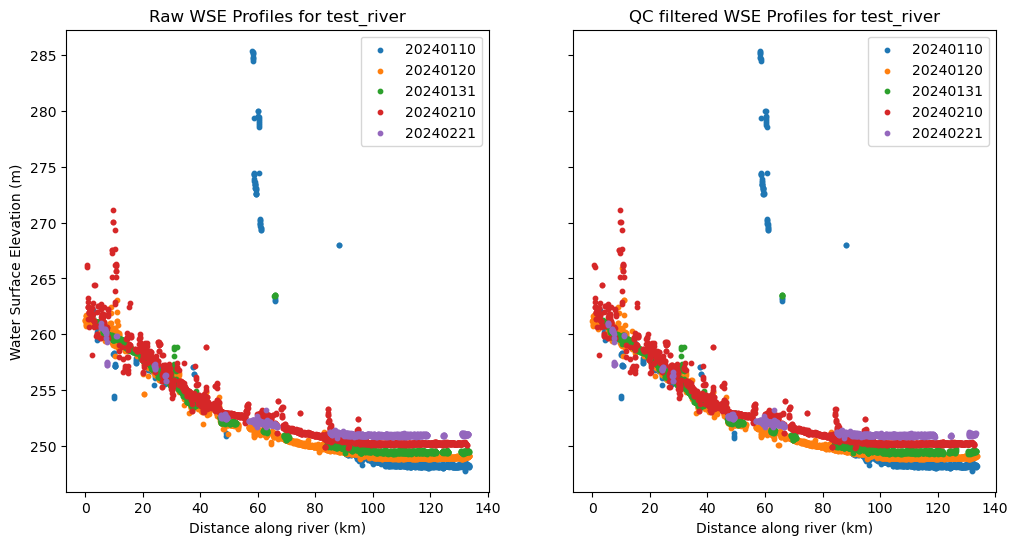

In [ ]:
# Step 4: calculate median WSE for each buffer node to build WSE profile
output_path=os.path.join(home_dir, river_name, "profiles.csv")
profile_range=(0, np.inf) # if the profile needs to be cutted, change this parameter
agg_func = "median" # aggregation function to calculate WSE for each node; currently only support "median"
# keep quality flag values for the median calculation
keep_qual_groups=["interferogram_qual", "classification_qual", "geolocation_qual", "sig0_qual"]
# smooth parameters
frac_list=[0.01, 0.05, 0.1, 0.2] # multiple LOWESS fractions to try
it=3 # number of iterations for LOWESS
seg_location = [] # list of segment locations to apply different smoothing, e.g., [20, 30] to have three segments: 0-20km, 20-30km, 30-end

profile = Profile(home_dir=home_dir,
                  riv_name=river_name,
                  node_path=river.node_export_path,
                  buffer_path=river.buffer_export_path,
                  pixc_dir = os.path.join(home_dir, river_name, pixc_dirname),
                  pixc_water_dir = os.path.join(home_dir, river_name, pixc_water_dir_name),
                  pixc_water_qc_filtered_dir = os.path.join(home_dir, river_name, pixc_qc_dirname),
                  output_path=output_path
                  )
# build WSE profiles for all dates
profile.build_wse_profiles_over_time(profile_range=profile_range, 
                                    agg_func = agg_func,
                                    keep_qual_groups=keep_qual_groups,
                                    frac_list=frac_list,
                                    it=it,
                                    seg_location=seg_location
                                    )
# data exported to "profiles.csv" under each river folder
# plot WSE profiles for all dates with a chosen smoothing fraction
profile.plot_wse_profile(frac=0.1)